# Import libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

In [3]:
import torch, torchvision 
from torch import optim
from torchvision import transforms
from torchvision.transforms import ToTensor

# Data Preprocessing

(512, 640, 3)


(-0.5, 639.5, 511.5, -0.5)

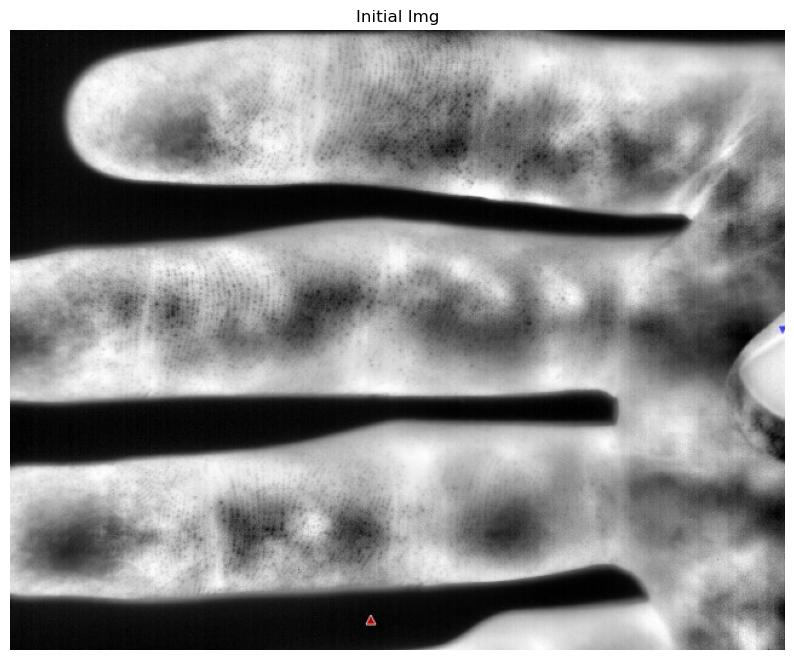

In [4]:
# Import data 
image_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/raw/8.bmp'
img = cv2.imread(image_path)

print(img.shape)

# show the image 
plt.figure(figsize = (10, 10))
plt.imshow(img, cmap = 'gray')
plt.title("Initial Img")
plt.axis("off")

# **Loading the CIFAR-10 Dataset**

In [4]:
# Download the dataset and store it locally. 
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
print(train_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


In [11]:
# In this dataset, we have 10 unique items
classes = train_data.classes

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Image data is stored inside train_data.data

In [17]:
print(type(train_data))
print()
print("Shape of the train_data.data:", train_data.data.shape)
print(type(train_data.data), " Number of data:",len(train_data.data))
print()
print(train_data[0], "--",type(train_data[0]), "Length:",len(train_data[0]), "--")
print(type(train_data[0][0]), type(train_data[0][1]))

<class 'torchvision.datasets.cifar.CIFAR10'>

Shape of the train_data.data: (50000, 32, 32, 3)
<class 'numpy.ndarray'>  Number of data: 50000

(<PIL.Image.Image image mode=RGB size=32x32 at 0x30FBFC640>, 6) -- <class 'tuple'> Length: 2 --
<class 'PIL.Image.Image'> <class 'int'>


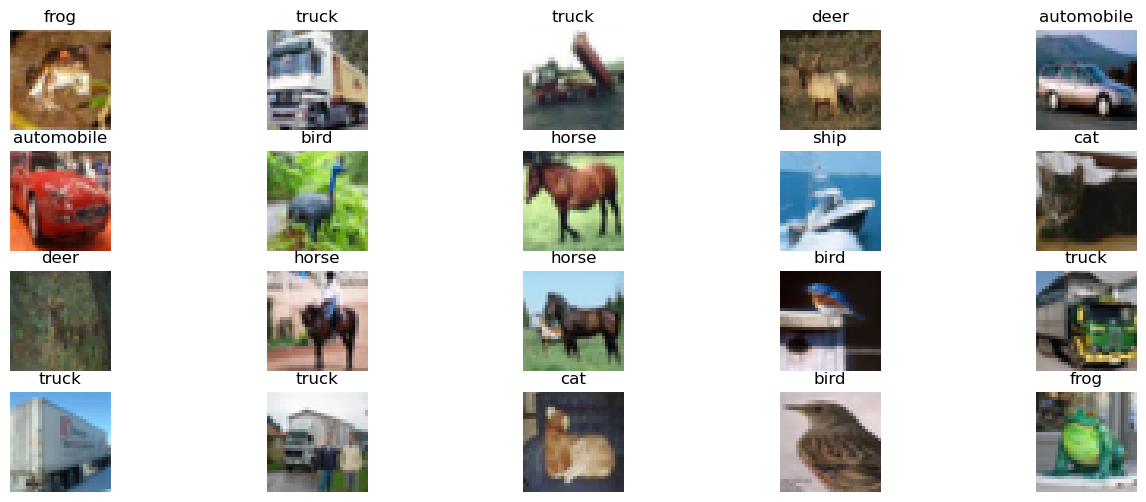

In [5]:
plt.figure(figsize = (16,6))
imgs_per_row = 5
total_imgs = 20
for i in range(total_imgs):
    #          (rows, cols, the nth plot)
    plt.subplot(math.ceil(total_imgs/imgs_per_row), imgs_per_row, 1 + i)
    plt.axis("off")
    plt.title(train_data.classes[train_data[i][1]])
    plt.imshow(train_data[i][0])

## Applying Transformation
Every thing in deep learning is in the form of Tensors. We normally apply normalization on these images, so that all the tensors are inthe same range of [-1, 1]. We will be using methods provided by torchvision.transform to approach this. 
#### Documentations: 
#### <a>https://pytorch.org/vision/0.11/transforms.html<a> | <a>https://pytorch.org/vision/stable/transforms.html<a>

<class 'torchvision.transforms.transforms.Compose'>


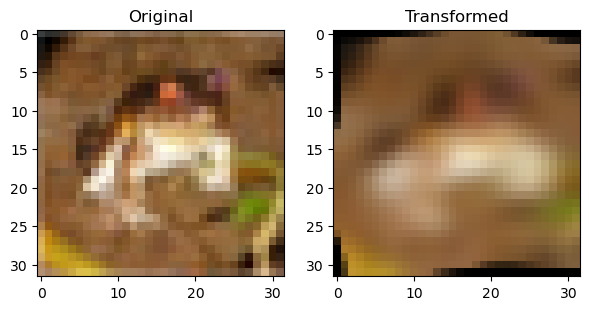

In [43]:
# Testing out the transforms.compose function
img = train_data[0][0]

trans = transforms.Compose([        
        transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])

print(type(trans))

# Apply this transformation to the image.
img_t = trans(img)

# Display images
plt.figure(figsize = (7, 7))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Transformed")
plt.imshow(img_t)

# **Batching the data and Shuffling**
AI models are trained in batches, therefore the "Stochastic" in the SGD term. We can certainly batch the images manually, keep track of which label goes where and then wrap an iterator around it to return a single batch of images when iterated on. However, it requires a lot of works and we can simply use DataLoader class to do some of this heavy lifting.

In [6]:
from torch.utils.data import DataLoader
import multiprocess
import psutil

In [7]:
# Let's figure out how many cores we have. I am running a 1st gen Mac M1 Pro.
print(multiprocess.cpu_count())

10


**DataLoader needs the dataset to be in Tensors** and hence we must first transform it into that.

In [8]:
convert = transforms.Compose([
        transforms.ToTensor(), # converting the data to Tesnor for dataloader
        transforms.transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=convert)

Files already downloaded and verified


### As not all CPU on the M1 chip are performance cores, with some being energy or low power cores, we can go with 4 cores as the number of workers.

In [9]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True, num_workers = 4)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### In Deep Learning, batch size refers to the number of samples (examples) processed together in a single iteration during training or inference (prediction). Instead of processing the entire dataset at once, the data is divided into smaller batches, and model operates on these batches iteratively.

In [12]:
batch_images, batch_labels = next(iter(train_loader))  # Get a batch.

print(batch_images.shape)
print([classes[l] for l in batch_labels])

/Users/rickysu/miniforge3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rickysu/miniforge3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <957F9F9F-D6BE-35CA-AEFE-BC189B7B2170> /Users/rickysu/miniforge3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7856C0E5-3D52-39C7-8515-71217150BD2E> /Users/rickysu/miniforge3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/rickysu/miniforge3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rickysu/miniforge3/lib/python3.10/s

torch.Size([10, 3, 32, 32])
['bird', 'truck', 'dog', 'ship', 'airplane', 'automobile', 'airplane', 'truck', 'airplane', 'truck']


In [13]:
# torch.Size([10(Batch size), 3(Channels), 32(Width), 32(Height)]) ---> 4 Dimension
# Batch size: 10 images are processed together in a single batch.

batch_images[0].shape

torch.Size([3, 32, 32])

**Note** - That when PIL images are converted to tensors using ToTensor() their representation is changed from (batchSize, h, w, channels) to (batchSize, channels, w, h). This is also how all Pytorch tensor related methods expect the iamge to be.

In [14]:
print(batch_images.shape, type(batch_images))

drawable = batch_images.permute(0, 2, 3, 1)  # Permuting the order so we can easily draw it out.
print(drawable.shape, type(drawable))

torch.Size([10, 3, 32, 32]) <class 'torch.Tensor'>
torch.Size([10, 32, 32, 3]) <class 'torch.Tensor'>


In [15]:
print(type(drawable[0]))

<class 'torch.Tensor'>


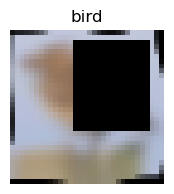

In [27]:
plt.figure(figsize=(2, 2))
plt.title(classes[batch_labels[0]])
plt.axis('off')
# valid image label don't take the batch size ---> Valid: (W, H, C)
plt.imshow(drawable[0])

# CNN Architecture 

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [50]:
class CNNs(nn.Module):
    def __init__(self):
        super(CNNs, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 3, stride = (1,1)) #shrink the size by 2 

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 3, stride = (1,1)) #shrink the size by 2 

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    # progresses data across layers  
    def foward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)

        x = x.view(-1, 64 * 6 * 6) # Flatten out the image.
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        
        

In [41]:
img_rand = torch.rand(3,32,32)
print(img_rand.shape)

conv1 = nn.Conv2d(3, 32, 3)
img_rand = conv1(img_rand)
print(img_rand.shape)
mp = nn.MaxPool2d(2, 2)
img_rand = mp(img_rand)
print(img_rand.shape)

conv2 = nn.Conv2d(32, 64, 3)
img_rand = conv2(img_rand)
print(img_rand.shape)
img_rand = mp(img_rand)
print(img_rand.shape)

torch.Size([3, 32, 32])
torch.Size([32, 30, 30])
torch.Size([32, 15, 15])
torch.Size([64, 13, 13])
torch.Size([64, 6, 6])


It seems like the dimension before we flatten will be (16, 5, 5)

In [49]:
model = CNNs()
print(model)

CNNs(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxPool1): MaxPool2d(kernel_size=3, stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxPool2): MaxPool2d(kernel_size=3, stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
